C:\Users\shale\AppData\Local\Temp\ipykernel_23080\1350257228.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load('latent_dataset.pt')


Epoch 1/2, Loss: 2.897915151384142
Epoch 2/2, Loss: 2.9157160917917886
[[0.5462889  0.541771   0.54097426 0.5442485 ]
 [0.5502151  0.5431725  0.54663634 0.54986525]
 [0.5469131  0.53906125 0.54326725 0.54859436]
 [0.55036694 0.5432585  0.54614216 0.5570344 ]]
[[0.5462847  0.54178405 0.5408874  0.5442641 ]
 [0.55017143 0.5432171  0.54661113 0.549825  ]
 [0.54696035 0.5391322  0.5432379  0.5486051 ]
 [0.5503898  0.54320556 0.5461303  0.5570283 ]]
[[0.5463347  0.5418717  0.5409209  0.5442656 ]
 [0.55018526 0.54323506 0.54658824 0.5498141 ]
 [0.54698616 0.5390901  0.5432423  0.548595  ]
 [0.5502671  0.54319304 0.5461281  0.557     ]]
[[0.54632986 0.5418669  0.54089236 0.544275  ]
 [0.5501465  0.5430952  0.5466105  0.54982847]
 [0.54692346 0.5391494  0.5432668  0.5486856 ]
 [0.5502921  0.54317623 0.54607785 0.557032  ]]
[[0.5463431  0.5418266  0.5408919  0.5442332 ]
 [0.5501736  0.5431339  0.5466335  0.54982656]
 [0.5469367  0.53910077 0.5432952  0.54863334]
 [0.5502976  0.54325694 0.546141

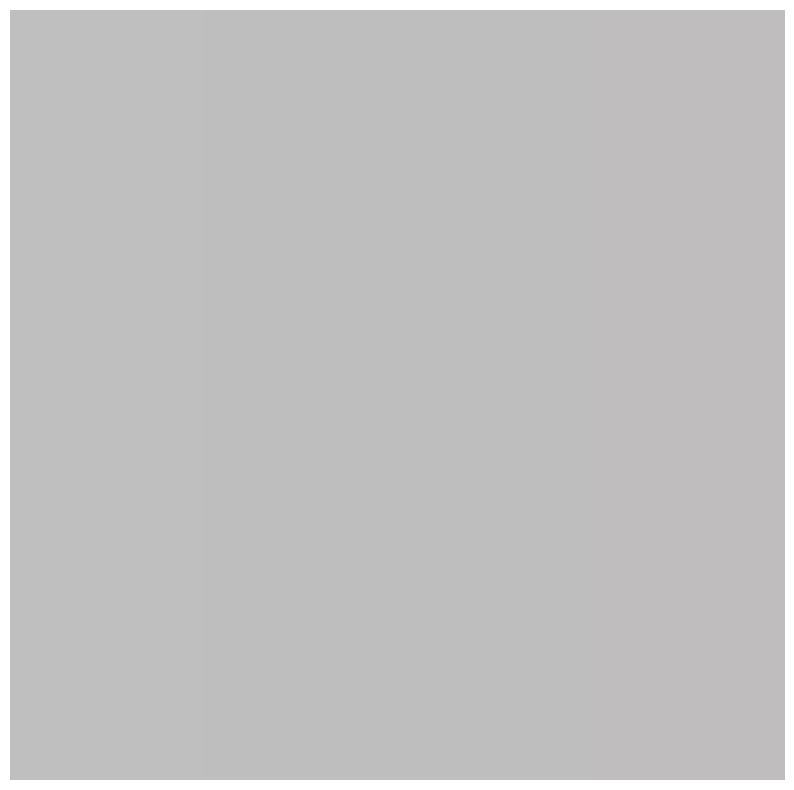

In [1]:
import sys
import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True
import numpy as np
torch.set_float32_matmul_precision('medium')
import h5py
from tqdm.auto import tqdm
import dac
from audiotools import AudioSignal
import torchaudio
from torch import nn, optim
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader


class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, n_embeddings, embedding_dim):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p=0.2)
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels, embedding_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # x = self.dropout(F.relu(self.conv1(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x


class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_channels, out_channels):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p=0.2)
        self.conv1 = nn.ConvTranspose2d(embedding_dim, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # x = self.dropout(F.relu(self.conv1(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

class VectorQuantizer(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.n_embeddings = n_embeddings
        self.embeddings = nn.Embedding(n_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1 / n_embeddings, 1 / n_embeddings)
        self.commitment_cost = commitment_cost

    def forward(self, inputs):
        flat_input = inputs.view(-1, self.embedding_dim)
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embeddings.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        quantized = torch.index_select(self.embeddings.weight, 0, encoding_indices.view(-1))
        quantized = quantized.view(inputs.shape)

        # Commitment Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        return quantized, loss, encoding_indices


class VQVAE2(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, n_embeddings=512, embedding_dim=64):
        super(VQVAE2, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels, n_embeddings, embedding_dim)
        self.vq = VectorQuantizer(n_embeddings, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_channels, in_channels)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, _ = self.vq(z)
        x_recon = self.decoder(quantized)
        x_recon = F.interpolate(x_recon, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return x_recon, vq_loss


class SnippetDatasetHDF(Dataset):
    def __init__(self, hdf, scaling='minmax'):
        self.num_rows = 0
        self.size = int(3.4 * 24000)  # fixed size for samples
        self.scaling = scaling
        self.data = self.create_data(hdf)
        
        if scaling == 'standard':
            self.mean = self.data.mean()
            self.std =  self.data.std()
            self.data = (self.data - self.mean) / self.std
        
        elif scaling == 'minmax':
            self.min = self.data.min()
            self.max = self.data.max()
            self.data = (self.data - self.min) / (self.max - self.min)
    
    def __len__(self):
        return self.num_rows
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def create_data(self, hdf):
        data = []
        keys = list(hdf.keys())
        self.num_rows = len(keys)
        for key in tqdm(keys):
            sample = hdf[key]['audio'][:]
            if len(sample) > self.size:
                self.num_rows -= 1
                continue

            if len(sample) < self.size:
                sample = np.pad(sample, (0, self.size - len(sample)), 'constant')

            data.append(sample)
         
        return torch.tensor(np.array(data)).float()

    def retransform(self, data):
        if self.scaling == 'standard':
            return data * self.std + self.mean
        elif self.scaling == 'minmax':
            return data * (self.max - self.min) + self.min

def train_vqvae2(model, dataloader, epochs=2, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        running_loss = 0.0
        for latents in dataloader:
            optimizer.zero_grad()
            outputs, vq_loss = model(latents)
            loss = criterion(outputs, latents) + vq_loss
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader)}')


class LatentDataset(Dataset):
    def __init__(self, latents_tensor):
        self.latents_tensor = latents_tensor

    def __len__(self):
        return len(self.latents_tensor)

    def __getitem__(self, idx):
        return self.latents_tensor[idx]

loaded_data = torch.load('latent_dataset.pt')
latent_dataset = LatentDataset(loaded_data)
train_loader = DataLoader(latent_dataset, batch_size=8, shuffle=True)

vqvae2_model = VQVAE2()
train_vqvae2(vqvae2_model, train_loader)

def generate_samples(model, num_samples=1):
    model.eval() 
    with torch.no_grad():
        encoding_indices = torch.randint(0, model.vq.n_embeddings, (num_samples, 1)).to(next(model.parameters()).device)
        quantized_latents = model.vq.embeddings(encoding_indices).view(num_samples, model.vq.embedding_dim, 1, 1)
        generated_samples = model.decoder(quantized_latents)
        generated_waveform = generated_samples.cpu()
        plt.figure(figsize=(10, 10))
        plt.imshow(generated_waveform.squeeze().detach().cpu().numpy(), aspect='auto', origin='lower')
        plt.axis('off')
        generated_samples = generated_samples.unsqueeze(0) if generated_waveform.ndim == 1 else generated_waveform
        return generated_samples

generated_audio = generate_samples(vqvae2_model, num_samples=5)

for i, sample in enumerate(generated_audio):
    sample_np = sample.squeeze(0).cpu().numpy()
    print(sample_np)
    sample_np = sample_np.astype(np.float32)
    if np.max(np.abs(sample_np)) > 1.0:
        sample_np /= np.max(np.abs(sample_np))
    sample_np_int16 = (sample_np * 32767).astype(np.int16)
    torchaudio.save(f'generated_sample_{i}.wav', torch.tensor(sample_np_int16), 24000)


